# **Построение прототипа рекомендательной системы**

В рамках построения рекомендательной системы будем решать задачу многоклассовой классификации, т.к. результаты построения модели будет очень просто интерпретировать. Для оценки качества нашей модели будем использовать метрику Precision, которая показывает точность классификации целевой переменной.

## **0. Установка и импорт библиотек**

In [ ]:
# !pip install pandas
# !pip install scikit-learn
# !pip install lightgbm
# !pip install seaborn matplotlib
# !pip install gensim
# !pip install nltk

In [1]:
import re
import requests
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, precision_score
from sklearn.model_selection import train_test_split
from gensim.models import Word2Vec
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from lightgbm import LGBMClassifier

## **1. Загрузка данных**

In [2]:
df_ratings = pd.read_csv('data/ratings.csv')
df_ratings.head()

,user_id,book_id,rating
0,1,258,5
1,2,4081,4
2,2,260,5
3,2,9296,5
4,2,2318,3


In [3]:
print(f'Count of unique users: {df_ratings.user_id.nunique()}')
print(f'Count of unique books: {df_ratings.book_id.nunique()}')

Count of unique users: 53424
Count of unique books: 10000


In [4]:
df_ratings.isna().sum()

user_id    0
book_id    0
rating     0
dtype: int64

In [5]:
df_ratings.shape

(5976479, 3)

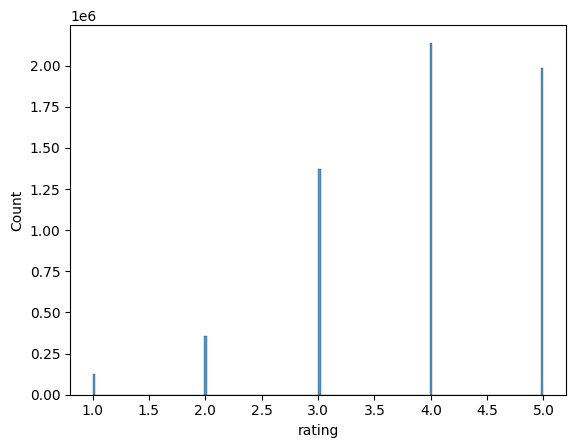

In [10]:
sns.histplot(df_ratings.rating)
plt.show()

In [3]:
X = df_ratings.drop('rating', axis=1)
y = df_ratings.rating
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, stratify=y)

In [4]:
df_books = pd.read_csv('data/books.csv')
df_books.head()

,book_id,goodreads_book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,...,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url
0,1,2767052,2767052,2792775,272,439023483,9.780439e+12,Suzanne Collins,2008.0,The Hunger Games,...,4780653,4942365,155254,66715,127936,560092,1481305,2706317,https://images.gr-assets.com/books/1447303603m...,https://images.gr-assets.com/books/1447303603s...
1,2,3,3,4640799,491,439554934,9.780440e+12,"J.K. Rowling, Mary GrandPré",1997.0,Harry Potter and the Philosopher's Stone,...,4602479,4800065,75867,75504,101676,455024,1156318,3011543,https://images.gr-assets.com/books/1474154022m...,https://images.gr-assets.com/books/1474154022s...
2,3,41865,41865,3212258,226,316015849,9.780316e+12,Stephenie Meyer,2005.0,Twilight,...,3866839,3916824,95009,456191,436802,793319,875073,1355439,https://images.gr-assets.com/books/1361039443m...,https://images.gr-assets.com/books/1361039443s...
3,4,2657,2657,3275794,487,61120081,9.780061e+12,Harper Lee,1960.0,To Kill a Mockingbird,...,3198671,3340896,72586,60427,117415,446835,1001952,1714267,https://images.gr-assets.com/books/1361975680m...,https://images.gr-assets.com/books/1361975680s...
4,5,4671,4671,245494,1356,743273567,9.780743e+12,F. Scott Fitzgerald,1925.0,The Great Gatsby,...,2683664,2773745,51992,86236,197621,606158,936012,947718,https://images.gr-assets.com/books/1490528560m...,https://images.gr-assets.com/books/1490528560s...


In [62]:
df_books.loc[:, df_books.isna().sum() > 0].isna().sum()

isbn                          700
isbn13                        585
original_publication_year      21
original_title                585
language_code                1084
dtype: int64

In [63]:
df_books.shape

(10000, 23)

In [5]:
df_genres = pd.read_json('data/goodreads_book_genres_initial.json', lines=True)
df_genres = df_genres[df_genres.book_id.isin(df_books.goodreads_book_id)]

In [7]:
df_genres.columns = ['book_id', 'genres_dict']
df_genres.head()

,book_id,genres_dict
3,6066819,"{'fiction': 555, 'romance': 23, 'mystery, thri..."
15,89375,"{'non-fiction': 534, 'history, historical fict..."
583,54270,"{'history, historical fiction, biography': 108..."
807,38568,"{'fantasy, paranormal': 1907, 'romance': 1598,..."
816,38562,"{'fantasy, paranormal': 1002, 'romance': 896, ..."


## **2. EDA**

### **2.1. Предобработка данных**

In [8]:
all_genres = set()
for dict_genre in df_genres.genres_dict:
    for elem in list(dict_genre.keys()):
        all_genres.add(elem.split(',')[0])

all_genres

{'children',
 'comics',
 'fantasy',
 'fiction',
 'history',
 'mystery',
 'non-fiction',
 'poetry',
 'romance',
 'young-adult'}

In [9]:
def simple_one_hot(genre_dict, genre):
    if genre in genre_dict:
        return 1
    return 0

In [10]:
for genre in all_genres:
    df_genres[genre] = df_genres.apply(lambda df: simple_one_hot(df['genres_dict'], genre), axis=1)

In [68]:
df_genres.head()

,book_id,genres_dict,young-adult,history,children,fantasy,mystery,romance,poetry,fiction,non-fiction,comics
3,6066819,"{'fiction': 555, 'romance': 23, 'mystery, thri...",0,0,0,0,0,1,0,1,0,0
15,89375,"{'non-fiction': 534, 'history, historical fict...",0,0,0,0,0,0,0,1,1,0
583,54270,"{'history, historical fiction, biography': 108...",0,0,0,0,0,0,0,0,1,0
807,38568,"{'fantasy, paranormal': 1907, 'romance': 1598,...",0,0,0,0,0,1,0,1,0,0
816,38562,"{'fantasy, paranormal': 1002, 'romance': 896, ...",0,0,0,0,0,1,0,1,0,0


In [17]:
df_genres.shape

(9996, 12)

In [11]:
X_train = X_train.merge(df_books[['book_id', 'goodreads_book_id']], left_on='book_id', right_on='book_id', how='left')
X_train = X_train.merge(df_genres, left_on='goodreads_book_id', right_on='book_id', how='left')
X_train.head()

,user_id,book_id_x,goodreads_book_id,book_id_y,genres_dict,children,mystery,young-adult,poetry,fiction,history,fantasy,romance,non-fiction,comics
0,15578,47,19063,19063.0,"{'fiction': 25304, 'history, historical fictio...",0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,7531,1943,16085481,16085481.0,"{'fiction': 1378, 'romance': 260}",0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,8708,898,43758,43758.0,"{'fantasy, paranormal': 2943, 'fiction': 1679,...",0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
3,34189,688,10847,10847.0,"{'non-fiction': 5268, 'history, historical fic...",0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,44501,977,15645,15645.0,"{'poetry': 2247, 'fiction': 1459, 'fantasy, pa...",0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0


In [12]:
users_profiles = X_train.groupby('user_id')[list(all_genres)].sum()
users_profiles.columns = ['user_' + name for name in list(users_profiles)]
users_profiles.head()

,user_children,user_mystery,user_young-adult,user_poetry,user_fiction,user_history,user_fantasy,user_romance,user_non-fiction,user_comics
user_id,,,,,,,,,,
1,5.0,0.0,30.0,1.0,78.0,0.0,0.0,32.0,21.0,0.0
2,8.0,0.0,16.0,3.0,31.0,0.0,0.0,16.0,24.0,0.0
3,8.0,0.0,21.0,13.0,65.0,0.0,0.0,13.0,21.0,0.0
4,21.0,0.0,44.0,3.0,87.0,0.0,0.0,24.0,15.0,0.0
5,9.0,0.0,12.0,1.0,66.0,0.0,0.0,19.0,2.0,0.0


In [71]:
users_profiles.shape

(53424, 10)

In [13]:
X_train.columns = ['book_' + item if item in all_genres else item for item in list(X_train)]
X_train = X_train.merge(users_profiles, left_on='user_id', right_on='user_id', how='left')
X_train.head()

,user_id,book_id_x,goodreads_book_id,book_id_y,genres_dict,book_children,book_mystery,book_young-adult,book_poetry,book_fiction,...,user_children,user_mystery,user_young-adult,user_poetry,user_fiction,user_history,user_fantasy,user_romance,user_non-fiction,user_comics
0,15578,47,19063,19063.0,"{'fiction': 25304, 'history, historical fictio...",0.0,0.0,1.0,0.0,1.0,...,28.0,0.0,64.0,8.0,107.0,0.0,0.0,46.0,27.0,0.0
1,7531,1943,16085481,16085481.0,"{'fiction': 1378, 'romance': 260}",0.0,0.0,0.0,0.0,1.0,...,5.0,0.0,31.0,0.0,94.0,0.0,0.0,53.0,12.0,0.0
2,8708,898,43758,43758.0,"{'fantasy, paranormal': 2943, 'fiction': 1679,...",0.0,0.0,0.0,0.0,1.0,...,24.0,0.0,47.0,10.0,83.0,0.0,0.0,39.0,13.0,0.0
3,34189,688,10847,10847.0,"{'non-fiction': 5268, 'history, historical fic...",0.0,0.0,0.0,0.0,1.0,...,19.0,0.0,49.0,9.0,92.0,0.0,0.0,33.0,33.0,0.0
4,44501,977,15645,15645.0,"{'poetry': 2247, 'fiction': 1459, 'fantasy, pa...",0.0,0.0,0.0,1.0,1.0,...,28.0,0.0,49.0,13.0,74.0,0.0,0.0,29.0,10.0,0.0


In [14]:
X_train.shape

(4183535, 25)

### **2.2. Векторизация наименования книг с помощью метода Word2Vec**

In [15]:
def text_cleaner(text):
    # Преобразование текста в нижний регистр
    text = text.lower()

    # Удаление лишних пробелов
    text = re.sub(r'\s+', ' ', text)

    # Преобразование сокращений
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"can't", "cannot", text)
    text = re.sub(r"n't", " not", text)
    text = re.sub(r"'ve", " have", text)
    text = re.sub(r"'ll", " will", text)
    text = re.sub(r"'d", " would", text)
    text = re.sub(r"'re", " are", text)
    text = re.sub(r"'s", " is", text)
    text = re.sub(r"'m", " am", text)

    # Удаление знаков препинания
    text = re.sub(r'[^\w\s]', '', text)

    # Удаление стоп-слов
    stop_words = set(stopwords.words('english'))
    tokens = word_tokenize(text)
    filtered_text = [word for word in tokens if word.lower() not in stop_words]

    # Лемматизация слов
    lemmatizer = WordNetLemmatizer()
    lemmatized_text = [lemmatizer.lemmatize(word) for word in filtered_text]

    # Объединение лемматизированных слов обратно в текст
    cleaned_text = ' '.join(lemmatized_text)

    return cleaned_text

In [16]:
df_books['cleaner_title'] = df_books['title'].apply(lambda x: text_cleaner(x))
df_books[['cleaner_title', 'title']].head()

,cleaner_title,title
0,hunger game hunger game 1,"The Hunger Games (The Hunger Games, #1)"
1,harry potter sorcerer stone harry potter 1,Harry Potter and the Sorcerer's Stone (Harry P...
2,twilight twilight 1,"Twilight (Twilight, #1)"
3,kill mockingbird,To Kill a Mockingbird
4,great gatsby,The Great Gatsby


In [17]:
sentences = df_books['cleaner_title'].apply(lambda x: x.split()).tolist()
model = Word2Vec(sentences, vector_size=100, min_count=1, sg=1)

def get_vector(sentence):
    vector = np.zeros(model.vector_size)
    count = 0
    for word in sentence:
        if word in model.wv:
            vector += model.wv[word]
            count += 1
    if count != 0:
        vector /= count
    return vector

df_books['title_vector'] = df_books['cleaner_title'].apply(lambda x: get_vector(x.split()))

**Сохраним полученные векторы в numpy файле**

In [46]:
np.save('data/title_vecs.npy', df_books['title_vector'])

In [26]:
df_books[['cleaner_title', 'title', 'title_vector']].head()

,cleaner_title,title,title_vector
0,hunger game hunger game 1,"The Hunger Games (The Hunger Games, #1)","[-0.08733851835131645, 0.09566921591758729, 0...."
1,harry potter sorcerer stone harry potter 1,Harry Potter and the Sorcerer's Stone (Harry P...,"[-0.0766112303826958, 0.1219545542927725, 0.01..."
2,twilight twilight 1,"Twilight (Twilight, #1)","[-0.11305688818295796, 0.13156368335088095, 0...."
3,kill mockingbird,To Kill a Mockingbird,"[-0.023392101284116507, 0.02806338353548199, 0..."
4,great gatsby,The Great Gatsby,"[-0.05120713380165398, 0.06413471780251712, 0...."


In [18]:
df_new = pd.DataFrame(df_books['title_vector'].values.tolist(), columns=[f'col_{i+1}' for i in range(100)])
df_result = pd.concat([df_books, df_new], axis=1)
df_result.head()

,book_id,goodreads_book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,...,col_91,col_92,col_93,col_94,col_95,col_96,col_97,col_98,col_99,col_100
0,1,2767052,2767052,2792775,272,439023483,9.780439e+12,Suzanne Collins,2008.0,The Hunger Games,...,0.207381,0.099816,0.159563,0.005415,0.321267,0.186485,0.147155,-0.197394,-0.025346,0.042650
1,2,3,3,4640799,491,439554934,9.780440e+12,"J.K. Rowling, Mary GrandPré",1997.0,Harry Potter and the Philosopher's Stone,...,0.264507,0.162414,0.267974,0.065166,0.480358,0.254292,0.178433,-0.289370,-0.115285,0.010069
2,3,41865,41865,3212258,226,316015849,9.780316e+12,Stephenie Meyer,2005.0,Twilight,...,0.242659,0.122541,0.200764,-0.008322,0.387703,0.219463,0.190414,-0.257156,-0.020559,0.059501
3,4,2657,2657,3275794,487,61120081,9.780061e+12,Harper Lee,1960.0,To Kill a Mockingbird,...,0.057735,0.025852,0.045729,0.000512,0.091002,0.049577,0.052170,-0.061870,-0.010827,0.008479
4,5,4671,4671,245494,1356,743273567,9.780743e+12,F. Scott Fitzgerald,1925.0,The Great Gatsby,...,0.112502,0.051260,0.088645,-0.000072,0.178594,0.105854,0.096889,-0.123649,-0.021868,0.026116


In [28]:
X_train = X_train.merge(df_result[[f'col_{i+1}' for i in range(100)] + ['book_id']], left_on='book_id_x', right_on='book_id')

In [29]:
X_train.head()

,user_id,book_id_x,goodreads_book_id,book_id_y,genres_dict,book_young-adult,book_history,book_children,book_fantasy,book_mystery,...,col_92,col_93,col_94,col_95,col_96,col_97,col_98,col_99,col_100,book_id
0,16216,4167,47613,47613.0,"{'fantasy, paranormal': 1847, 'young-adult': 6...",1.0,0.0,1.0,0.0,0.0,...,0.069645,0.118837,0.003741,0.232516,0.141470,0.108888,-0.146711,-0.015450,0.031955,4167
1,53312,5783,5130,5130.0,"{'fiction': 870, 'fantasy, paranormal': 65}",0.0,0.0,0.0,0.0,0.0,...,0.059543,0.085282,-0.002528,0.190214,0.111096,0.099239,-0.112318,-0.010560,0.012876,5783
2,50562,1204,17184,17184.0,"{'fiction': 3914, 'fantasy, paranormal': 724, ...",0.0,0.0,0.0,0.0,0.0,...,0.087973,0.146876,0.004522,0.281961,0.161551,0.131150,-0.172348,-0.017754,0.043874,1204
3,52505,118,7763,7763.0,"{'fiction': 2019, 'history, historical fiction...",1.0,0.0,0.0,0.0,0.0,...,0.048998,0.091974,0.002412,0.178564,0.101099,0.090507,-0.111351,-0.013139,0.028732,118
4,47927,77,38709,38709.0,"{'young-adult': 5068, 'fiction': 4929, 'childr...",1.0,0.0,1.0,0.0,0.0,...,0.107030,0.165665,0.009250,0.316893,0.185005,0.145145,-0.197566,-0.031993,0.031166,77


In [30]:
X_train.shape

(4183535, 126)

In [31]:
cols_for_using = [
    # 'rating',
    'book_mystery',
    'book_non-fiction',
    'book_romance',
    'book_fantasy',
    'book_poetry',
    'book_fiction',
    'book_young-adult',
    'book_history',
    'book_comics',
    'book_children',
    'user_mystery',
    'user_non-fiction',
    'user_romance',
    'user_fantasy',
    'user_poetry',
    'user_fiction',
    'user_young-adult',
    'user_history',
    'user_comics',
    'user_children']+[f'col_{i+1}' for i in range(100)]
X_train = X_train[cols_for_using]
X_train.fillna(0, inplace=True)
X_train.head()

,book_mystery,book_non-fiction,book_romance,book_fantasy,book_poetry,book_fiction,book_young-adult,book_history,book_comics,book_children,...,col_91,col_92,col_93,col_94,col_95,col_96,col_97,col_98,col_99,col_100
0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,...,0.143407,0.069645,0.118837,0.003741,0.232516,0.141470,0.108888,-0.146711,-0.015450,0.031955
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.102931,0.059543,0.085282,-0.002528,0.190214,0.111096,0.099239,-0.112318,-0.010560,0.012876
2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.177551,0.087973,0.146876,0.004522,0.281961,0.161551,0.131150,-0.172348,-0.017754,0.043874
3,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.104769,0.048998,0.091974,0.002412,0.178564,0.101099,0.090507,-0.111351,-0.013139,0.028732
4,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,...,0.187967,0.107030,0.165665,0.009250,0.316893,0.185005,0.145145,-0.197566,-0.031993,0.031166


In [48]:
# Проведем преодобработку тестовых данных аналогично тренировочным данным
X_test = X_test.merge(df_books[['book_id', 'goodreads_book_id']], left_on='book_id', right_on='book_id', how='left')
X_test = X_test.merge(df_genres, left_on='goodreads_book_id', right_on='book_id', how='left')
X_test.columns = ['book_'+item if item in all_genres else item for item in list(X_test)]
X_test = X_test.merge(users_profiles, left_on='user_id', right_on='user_id', how='left')
X_test = X_test.merge(df_result[[f'col_{i+1}' for i in range(100)] + ['book_id']], left_on='book_id_x', right_on='book_id')
X_test.fillna(0, inplace=True)

## **3. Modeling**

### **BaseLine**

Используем модель градиентного бустинга LightGBM

In [49]:
lgbm = LGBMClassifier()
lgbm.fit(X_train, y_train)
pred_train = lgbm.predict(X_train)
pred_test = lgbm.predict(X_test[cols_for_using])
print(f'Метрика Precision LGBMClassifier на тренировочной выборке: {precision_score(y_train, pred_train, average='micro')}')
print(f'Метрика Precision LGBMClassifier на тестовой выборке: {precision_score(y_test, pred_test, average='micro')}')

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.026081 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 26128
[LightGBM] [Info] Number of data points in the train set: 4183535, number of used features: 112
[LightGBM] [Info] Start training from score -3.873728
[LightGBM] [Info] Start training from score -2.811548
[LightGBM] [Info] Start training from score -1.472353
[LightGBM] [Info] Start training from score -1.027485
[LightGBM] [Info] Start training from score -1.103174
Метрика Precision LGBMClassifier на тренировочной выборке: 0.40749939943134217
Метрика Precision LGBMClassifier на тестовой выборке: 0.4060511650112887


На бейслане была получена метрика Precision 0.406. Однако данную модель попробуем доработать с помощью добавления новых данных в датасет, а также попробуем тюнить нашу модель.

## **4. Тюнинг модели**

### **4.1. Добавление дополнительных фичей в датасет**

In [19]:
df_add = pd.read_csv('data/book_descr.csv')
df_add.head()

,book_id,descr,descr_vecs
0,1,"In a future North America, where the rulers of...",[ 0.11025178 -0.21036306 -0.02822943 0.266000...
1,2,NaN,[-2.0151265 -0.5475724 -0.34907195 0.067971...
2,3,NaN,[-2.0151265 -0.5475724 -0.34907195 0.067971...
3,4,Harper Lee's Pulitzer Prize-winning masterwork...,[ 2.73116946e-01 -1.85827732e-01 -1.73755307e-...
4,5,A young man newly rich tries to recapture the ...,[ 0.07466012 -0.37611896 -0.02056331 0.190791...


In [53]:
df_add.shape

(10000, 3)

Векторизуем фичу descr с помощью нашей модели Word2Vec

In [20]:
# Перед векторизацией обработаем данные
df_add['descr'].fillna('clean', inplace=True)
df_add['descr'] = df_add['descr'].apply(lambda x: text_cleaner(x))

sentences = df_add['descr'].apply(lambda x: x.split()).tolist()
model = Word2Vec(sentences, vector_size=100, min_count=1, sg=1)
df_add['descr_vecs'] = df_add['descr'].apply(lambda x: get_vector(x.split()))
df_add.head()

C:\Users\Alex\AppData\Local\Temp\ipykernel_940\3366611258.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_add['descr'].fillna('clean', inplace=True)


,book_id,descr,descr_vecs
0,1,future north america ruler panem maintain cont...,"[-0.05336597199285669, 0.34430002953325, 0.177..."
1,2,clean,"[-0.03598746284842491, 0.21125879883766174, 0...."
2,3,clean,"[-0.03598746284842491, 0.21125879883766174, 0...."
3,4,harper lee pulitzer prizewinning masterwork ho...,"[-0.10804208103482696, 0.40752860400583835, 0...."
4,5,young man newly rich try recapture past win ba...,"[-0.026391513512602875, 0.3410316546048437, 0...."


Сохраним полученные векторы в файл

In [59]:
np.save('data/descr_vecs.npy', df_add['descr_vecs'])

In [21]:
df_add_new = pd.DataFrame(df_add['descr_vecs'].values.tolist(), columns=[f'col_add_{i+1}' for i in range(100)])
df_result = pd.concat([df_result, df_add_new], axis=1)
df_result.head()

,book_id,goodreads_book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,...,col_add_91,col_add_92,col_add_93,col_add_94,col_add_95,col_add_96,col_add_97,col_add_98,col_add_99,col_add_100
0,1,2767052,2767052,2792775,272,439023483,9.780439e+12,Suzanne Collins,2008.0,The Hunger Games,...,0.311935,0.083065,0.088581,-0.050388,0.410103,0.069512,0.074291,-0.110183,0.157729,-0.096011
1,2,3,3,4640799,491,439554934,9.780440e+12,"J.K. Rowling, Mary GrandPré",1997.0,Harry Potter and the Philosopher's Stone,...,0.152448,0.062284,0.068201,-0.040485,0.207145,0.018530,0.018568,-0.110194,0.069698,-0.042419
2,3,41865,41865,3212258,226,316015849,9.780316e+12,Stephenie Meyer,2005.0,Twilight,...,0.152448,0.062284,0.068201,-0.040485,0.207145,0.018530,0.018568,-0.110194,0.069698,-0.042419
3,4,2657,2657,3275794,487,61120081,9.780061e+12,Harper Lee,1960.0,To Kill a Mockingbird,...,0.365804,0.092556,0.126809,-0.086244,0.484615,0.035918,0.132607,-0.105441,0.133738,-0.116227
4,5,4671,4671,245494,1356,743273567,9.780743e+12,F. Scott Fitzgerald,1925.0,The Great Gatsby,...,0.403703,0.124041,0.092666,-0.013292,0.461600,0.086137,0.130874,-0.104773,0.199764,-0.124210


In [22]:
X_train = X_train.merge(df_result[[f'col_{i+1}' for i in range(100)] + [f'col_add_{i+1}' for i in range(100)] + ['book_id']], left_on='book_id_x', right_on='book_id')
X_train.head()

,user_id,book_id_x,goodreads_book_id,book_id_y,genres_dict,book_children,book_mystery,book_young-adult,book_poetry,book_fiction,...,col_add_92,col_add_93,col_add_94,col_add_95,col_add_96,col_add_97,col_add_98,col_add_99,col_add_100,book_id
0,15578,47,19063,19063.0,"{'fiction': 25304, 'history, historical fictio...",0.0,0.0,1.0,0.0,1.0,...,0.116254,0.095029,-0.097228,0.501506,0.003985,0.177621,-0.091259,0.134706,-0.085389,47
1,7531,1943,16085481,16085481.0,"{'fiction': 1378, 'romance': 260}",0.0,0.0,0.0,0.0,1.0,...,0.100934,0.104405,-0.051415,0.394199,0.053288,0.084322,-0.107416,0.182320,-0.136133,1943
2,8708,898,43758,43758.0,"{'fantasy, paranormal': 2943, 'fiction': 1679,...",0.0,0.0,0.0,0.0,1.0,...,0.048840,0.101115,-0.096053,0.401839,-0.006119,0.110288,-0.127115,0.084979,-0.040715,898
3,34189,688,10847,10847.0,"{'non-fiction': 5268, 'history, historical fic...",0.0,0.0,0.0,0.0,1.0,...,0.062284,0.068201,-0.040485,0.207145,0.018530,0.018568,-0.110194,0.069698,-0.042419,688
4,44501,977,15645,15645.0,"{'poetry': 2247, 'fiction': 1459, 'fantasy, pa...",0.0,0.0,0.0,1.0,1.0,...,0.062284,0.068201,-0.040485,0.207145,0.018530,0.018568,-0.110194,0.069698,-0.042419,977


In [23]:
cols_for_using = [
    # 'rating',
    'book_mystery',
    'book_non-fiction',
    'book_romance',
    'book_fantasy',
    'book_poetry',
    'book_fiction',
    'book_young-adult',
    'book_history',
    'book_comics',
    'book_children',
    'user_mystery',
    'user_non-fiction',
    'user_romance',
    'user_fantasy',
    'user_poetry',
    'user_fiction',
    'user_young-adult',
    'user_history',
    'user_comics',
    'user_children'] + [f'col_{i+1}' for i in range(100)] + [f'col_add_{i+1}' for i in range(100)]
X_train = X_train[cols_for_using]
X_train.fillna(0, inplace=True)
X_train.head()

,book_mystery,book_non-fiction,book_romance,book_fantasy,book_poetry,book_fiction,book_young-adult,book_history,book_comics,book_children,...,col_add_91,col_add_92,col_add_93,col_add_94,col_add_95,col_add_96,col_add_97,col_add_98,col_add_99,col_add_100
0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.378696,0.116254,0.095029,-0.097228,0.501506,0.003985,0.177621,-0.091259,0.134706,-0.085389
1,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.318817,0.100934,0.104405,-0.051415,0.394199,0.053288,0.084322,-0.107416,0.182320,-0.136133
2,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.288334,0.048840,0.101115,-0.096053,0.401839,-0.006119,0.110288,-0.127115,0.084979,-0.040715
3,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.152448,0.062284,0.068201,-0.040485,0.207145,0.018530,0.018568,-0.110194,0.069698,-0.042419
4,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.152448,0.062284,0.068201,-0.040485,0.207145,0.018530,0.018568,-0.110194,0.069698,-0.042419


In [24]:
# Проведем преодобработку тестовых данных аналогично тренировочным данным
X_test = X_test.merge(df_books[['book_id', 'goodreads_book_id']], left_on='book_id', right_on='book_id', how='left')
X_test = X_test.merge(df_genres, left_on='goodreads_book_id', right_on='book_id', how='left')
X_test.columns = ['book_'+item if item in all_genres else item for item in list(X_test)]
X_test = X_test.merge(users_profiles, left_on='user_id', right_on='user_id', how='left')
X_test = X_test.merge(df_result[[f'col_{i+1}' for i in range(100)] + [f'col_add_{i+1}' for i in range(100)] + ['book_id']], left_on='book_id_x', right_on='book_id')
X_test.fillna(0, inplace=True)

Проверим метрику после добавления в датасет новых переменных

In [25]:
lgbm = LGBMClassifier()
lgbm.fit(X_train, y_train)
pred_train = lgbm.predict(X_train)
pred_test = lgbm.predict(X_test[cols_for_using])
print(f'Метрика Precision LGBMClassifier на тренировочной выборке: {precision_score(y_train, pred_train, average='micro')}')
print(f'Метрика Precision LGBMClassifier на тестовой выборке: {precision_score(y_test, pred_test, average='micro')}')

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 2.357660 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 51454
[LightGBM] [Info] Number of data points in the train set: 4183535, number of used features: 212
[LightGBM] [Info] Start training from score -3.873728
[LightGBM] [Info] Start training from score -2.811548
[LightGBM] [Info] Start training from score -1.472353
[LightGBM] [Info] Start training from score -1.027485
[LightGBM] [Info] Start training from score -1.103174
Метрика Precision LGBMClassifier на тренировочной выборке: 0.4079910888757952
Метрика Precision LGBMClassifier на тестовой выборке: 0.4068548710946912


Метрика Precision после добавления новых переменных почти не изменилась

### **4.2. Подбор параметров модели**

Попробуем немного тюнить параметры модели

In [27]:
lgbm = LGBMClassifier(n_estimators=300)
lgbm.fit(X_train, y_train)
pred_train = lgbm.predict(X_train)
pred_test = lgbm.predict(X_test[cols_for_using])
print(f'Метрика Precision LGBMClassifier на тренировочной выборке: {precision_score(y_train, pred_train, average='micro'):.6f}')
print(f'Метрика Precision LGBMClassifier на тестовой выборке: {precision_score(y_test, pred_test, average='micro'):.6f}')

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 2.257573 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 51454
[LightGBM] [Info] Number of data points in the train set: 4183535, number of used features: 212
[LightGBM] [Info] Start training from score -3.873728
[LightGBM] [Info] Start training from score -2.811548
[LightGBM] [Info] Start training from score -1.472353
[LightGBM] [Info] Start training from score -1.027485
[LightGBM] [Info] Start training from score -1.103174
Метрика Precision LGBMClassifier на тренировочной выборке: 0.422748
Метрика Precision LGBMClassifier на тестовой выборке: 0.418799


Как видно из полученного результата, тюнинг модели дал гораздо больший прирост метрики Precision, чем добавление дополнительных фичей.
Таким образом, в дальнейшем можно будет отказаться от сбора и обработки дополнительных данных в пользу увеличения производительности.